In [19]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import Pool, cv,CatBoostRegressor

In [2]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

# Check is noiced

In [14]:
data = train_df[train_df['label'] == 1].drop(['label'], axis=1).dropna()
# data = train_df.drop(['label'], axis=1).dropna()

In [15]:
data.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,drop_hour,drop_minute,pick_cluster,is_more_than_one_day,distance_km,fare_per_km,pickup_timeslot,day_of_week,is_weekday,cal_time_difference
0,10.5,834.0,56.0,0.0000,64.0,270.32,1,0,20,1,0,34,1,0,5.072065,53.190982,0,4,1,6.0
1,10.5,791.0,47.0,0.0000,134.0,197.85,1,0,56,1,1,9,1,0,3.151780,62.575517,0,4,1,-11.0
2,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1,8,1,1,26,1,0,6.302418,47.785178,0,4,1,-7.0
3,10.5,598.0,271.0,15.6638,68.0,82.30,1,2,27,1,2,37,1,0,0.862654,94.309954,0,4,1,2.0
4,10.5,3407.0,182.0,0.0000,112.0,1065.02,1,5,38,1,6,35,3,0,24.078955,44.211964,3,4,1,13.0


In [16]:
cat_features = ['pick_cluster','is_more_than_one_day','pickup_timeslot',
       'day_of_week', 'is_weekday']

features = [
    'additional_fare',
#     'duration',
#     'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'pick_cluster', 
    'is_more_than_one_day', 
    'distance_km',
    'pickup_timeslot',
    'day_of_week', 
    'is_weekday',
#     'fare'
]

In [17]:
X = data[features]
y = data['meter_waiting_fare'].values

In [18]:
train_df_X = train_df[features]
train_df_pool = Pool(data=train_df_X,cat_features=cat_features)
test_df_X = test_df[features]
test_df_pool = Pool(data=test_df_X,cat_features=cat_features)

In [19]:
train_df_preds = np.zeros(train_df.shape[0])
test_df_preds = np.zeros(test_df.shape[0])

In [20]:
params = {
    'loss_function':'RMSE',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'RMSE'
}

In [21]:
kf = KFold(n_splits=3)

In [22]:
validation_scores = []
models = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostRegressor(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    validation_score = model.best_score_['validation']['RMSE']
    print('Validation RMSE',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    
    train_df_preds += model.predict(train_df_pool)
    test_df_preds += model.predict(test_df_pool)

Learning rate set to 0.071592
0:	learn: 261.5480287	test: 137.0864080	best: 137.0864080 (0)	total: 9.69ms	remaining: 9.68s
10:	learn: 221.1924348	test: 136.6525032	best: 136.6525032 (10)	total: 50.8ms	remaining: 4.57s
20:	learn: 186.2653844	test: 136.2797887	best: 136.2797887 (20)	total: 91ms	remaining: 4.24s
30:	learn: 158.5017520	test: 136.3666295	best: 136.2794742 (21)	total: 129ms	remaining: 4.04s
40:	learn: 137.3439883	test: 136.1820957	best: 136.1798690 (36)	total: 167ms	remaining: 3.9s
50:	learn: 117.2958420	test: 136.1923677	best: 136.1798690 (36)	total: 213ms	remaining: 3.97s
60:	learn: 100.9794269	test: 136.2000956	best: 136.1636805 (53)	total: 258ms	remaining: 3.97s
70:	learn: 89.3773979	test: 136.2286574	best: 136.1395055 (67)	total: 288ms	remaining: 3.76s
80:	learn: 79.4442633	test: 136.1564937	best: 136.1395055 (67)	total: 327ms	remaining: 3.71s
90:	learn: 70.3715441	test: 136.1801003	best: 136.1353112 (81)	total: 369ms	remaining: 3.69s
100:	learn: 64.2652812	test: 136.14

In [23]:
np.mean(validation_scores), np.std(validation_scores)

(195.95958425419863, 122.11844166328636)

In [ ]:
(418.17657240002376, 118.91645261628634)

In [36]:
best_model = models[np.argmax(validation_scores)]

In [37]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,meter_waiting_fare,39.737553
1,is_more_than_one_day,36.444741
2,pick_cluster,11.132432
3,distance_km,5.383907
4,additional_fare,4.553273
5,meter_waiting_till_pickup,2.272128
6,is_weekday,0.282623
7,day_of_week,0.109541
8,pickup_timeslot,0.083801


# Predict noice

In [3]:
cat_features = [
    'pick_cluster',
    'is_more_than_one_day',
    'pickup_timeslot',
    'day_of_week', 
    'is_weekday']

features = [    
#     'meter_waiting_fare',
#     'meter_waiting_till_pickup', 
    'pick_cluster', 
    'is_more_than_one_day', 
    'distance_km',
    'pickup_timeslot',
    'day_of_week', 
    'is_weekday',
    'additional_fare'
]

In [4]:
# data = train_df[train_df['label'] == 1].drop(['label'], axis=1).dropna()
data = train_df.drop(['label'], axis=1).dropna()

In [5]:
target_cols = ['duration','meter_waiting','fare']

In [6]:
params = {
    'loss_function':'RMSE',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'RMSE'
}

In [7]:
def get_cv_scores_and_pred(target_col, train_set=data, train_df=train_df, test_df=test_df):
    cols = list(filter(lambda col: col != target_col, features))
    X = data[cols]
    y = data[target_col].values
    
    train_df_X = train_df[cols]
    train_df_pool = Pool(data=train_df_X,cat_features=cat_features)
    test_df_X = test_df[cols]
    test_df_pool = Pool(data=test_df_X,cat_features=cat_features)
    
    train_df_preds = np.zeros(train_df.shape[0])
    test_df_preds = np.zeros(test_df.shape[0])
    
    kf = KFold(n_splits=3)
    validation_scores = []
    models = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
        test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
        model = CatBoostRegressor(**params)
        model.fit(X=train_pool, eval_set=test_pool,verbose=False)
        validation_score = model.best_score_['validation']['RMSE']
        print('Validation RMSE:',validation_score,' best iteration:',model.get_best_iteration())
        validation_scores.append(validation_score)
        models.append(model)

        train_df_preds += model.predict(train_df_pool)
        test_df_preds += model.predict(test_df_pool)
    print(target_col,np.mean(validation_scores), np.std(validation_scores))
    
    train_df[f'predicted_{target_col}'] = train_df_preds/3
    test_df[f'predicted_{target_col}'] = test_df_preds/3
    
    train_df[f'predicted_{target_col}_difference'] = train_df[f'{target_col}'] - train_df[f'predicted_{target_col}']
    test_df[f'predicted_{target_col}_difference'] = test_df[f'{target_col}'] - test_df[f'predicted_{target_col}']
    
    train_df[f'predicted_{target_col}_difference_per_{target_col}'] = train_df[f'predicted_{target_col}_difference'] / (train_df[f'{target_col}']+1)
    test_df[f'predicted_{target_col}_difference_per_{target_col}'] = test_df[f'predicted_{target_col}_difference']  / (test_df[f'{target_col}']+1)
    

In [8]:
for col in target_cols:
    get_cv_scores_and_pred(col)

Validation RMSE: 10390.879453054471  best iteration: 54
Validation RMSE: 5073.973496989087  best iteration: 8
Validation RMSE: 6457.062825445136  best iteration: 19
duration 7307.3052584962315 2252.3404690279212
Validation RMSE: 9942.141040112147  best iteration: 121
Validation RMSE: 4936.107477989613  best iteration: 10
Validation RMSE: 6981.797639924403  best iteration: 27
meter_waiting 7286.682052675387 2055.0440198250726
Validation RMSE: 638.9213725893073  best iteration: 149
Validation RMSE: 417.27003109608813  best iteration: 141
Validation RMSE: 555.8413509436846  best iteration: 17
fare 537.3442515430266 91.42915768001032


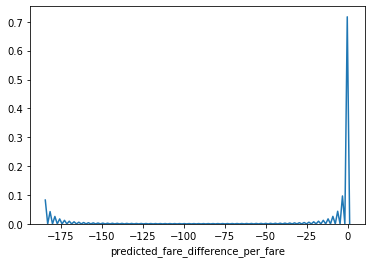

In [9]:
sns.distplot(train_df[train_df['label']==1]['predicted_fare_difference_per_fare'], hist=False)

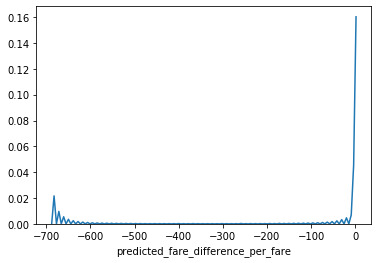

In [10]:
sns.distplot(train_df[train_df['label']==0]['predicted_fare_difference_per_fare'], hist=False)

In [11]:
train_df['predicted_fare_per_distance'] = train_df['predicted_fare'] / (train_df['distance_km'] + 1)

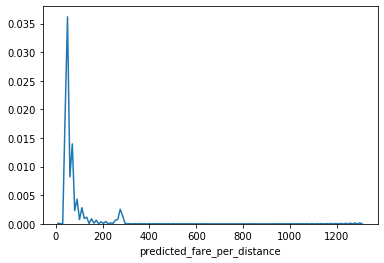

In [12]:
sns.distplot(train_df[train_df['label']==1]['predicted_fare_per_distance'], hist=False)

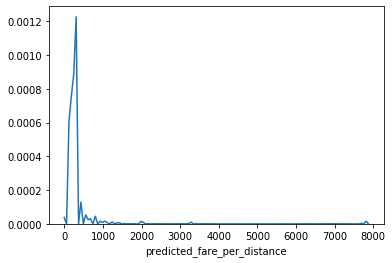

In [13]:
sns.distplot(train_df[train_df['label']==0]['predicted_fare_per_distance'], hist=False)

In [14]:
train_df['predicted_fare_per_distance_difference'] = train_df['predicted_fare_per_distance'] - train_df['fare_per_km']

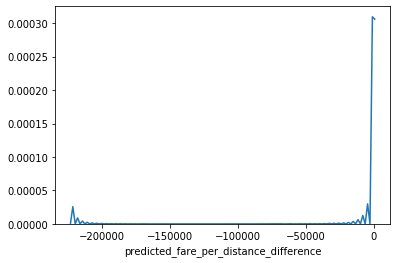

In [15]:
sns.distplot(train_df[train_df['label']==1]['predicted_fare_per_distance_difference'], hist=False)

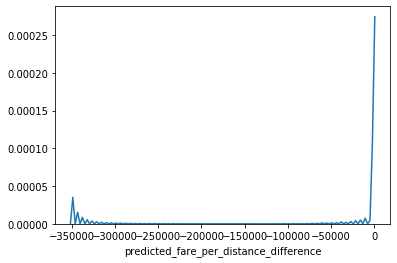

In [16]:
sns.distplot(train_df[train_df['label']==0]['predicted_fare_per_distance_difference'], hist=False)

In [17]:
train_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,...,predicted_duration_difference,predicted_duration_difference_per_duration,predicted_meter_waiting,predicted_meter_waiting_difference,predicted_meter_waiting_difference_per_meter_waiting,predicted_fare,predicted_fare_difference,predicted_fare_difference_per_fare,predicted_fare_per_distance,predicted_fare_per_distance_difference
0,10.5,834.0,56.0,0.0000,64.0,270.32,1,0,20,1,...,-715.553335,-0.856950,406.333497,-350.333497,-6.146202,286.303176,-15.983176,-0.058909,47.150878,-6.040103
1,10.5,791.0,47.0,0.0000,134.0,197.85,1,0,56,1,...,-444.793042,-0.561607,371.382428,-324.382428,-6.757967,222.587072,-24.737072,-0.124401,53.612447,-8.963069
2,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1,8,1,...,-535.766120,-0.492432,436.040285,-356.040285,-4.395559,322.818016,-21.178016,-0.069978,44.207006,-3.578173
3,10.5,598.0,271.0,15.6638,68.0,82.30,1,2,27,1,...,-703.332872,-1.174178,453.181017,-182.181017,-0.669783,189.009715,-106.709715,-1.281029,101.473312,7.163358
4,10.5,3407.0,182.0,0.0000,112.0,1065.02,1,5,38,1,...,583.768705,0.171294,583.375577,-401.375577,-2.193309,937.113875,127.906125,0.119985,37.366545,-6.845420


In [18]:
train_df.to_csv('train_df_reg.csv',index=False)
test_df.to_csv('test_df_reg.csv',index=False)